In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


## Advanced Lane Finding Pipeline  

## - Calibrate the Camera  

- Compute the camera calibration matrix and distortion coefficients. it should be done only once. 
- Apply the calibrated parameters to undistort each new frame. 

## - Apply Thresholds  

We try out various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible. 

## - Perspective Transform  

- Identify four source points for the perspective transform. In this case, we assume the road is a flat plane. This isn't strictly true, but it can serve as an approximation for this project. 

- Pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above. The easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

- Those same four source points will now work to transform any image (again, under the assumption that the road is flat and the camera perspective hasn't changed). When applying the transform to new images, the test of whether or not you got the transform correct, is that the lane lines should appear parallel in the warped images, whether they are straight or curved.

## - Implementation 

### 1. Defining `Camera` Class  

- `Camera` class is defined keep camera parameters as well as implemnt the methods to transform images. These methods are:   
  - `calibrate` 
  - `undistort` 
  - `transform` 
  
### 2. Implementing `undistort` and `transform` Nested Methods

After calibration, here are the following steps: 

- Undistort the image using `cv2.undistort()` with mtx and dist
- Convert to grayscale
- Find the chessboard corners
- Draw corners
- Define 4 source points (the outer 4 corners detected in the chessboard pattern)
- Define 4 destination points (must be listed in the same order as src points!)
- Use `cv2.getPerspectiveTransform()` to get M, the transform matrix
- use `cv2.warpPerspective()` to apply M and warp your image to a top-down view  

***

**Note:** Source points are the `x` and `y` pixel values of any four corners on the chessboard. They can be extracted from the corners array output from `cv2.findChessboardCorners()`. So, the destination points are the `x` and `y` pixel values of where we want those four corners to be mapped to in the output image.  


### Some OpenCV functions used for this project

- `cv2.inRange()` for color selection  
- `cv2.fillPoly()` for regions selection  
- `cv2.line()` to draw lines on an image given endpoints  
- `cv2.addWeighted()` to coadd / overlay two images  
- `cv2.cvtColor()` to grayscale or change color  
- `cv2.imwrite()` to output images to file  
- `cv2.bitwise_and()` to apply a mask to an image


In [5]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob
import matplotlib
import os

### Read in a Sample Image

In [ ]:
image = mpimg.imread("test_images/straight_lines1.jpg")
print("This image is:", type(image), "with dimensions:", image.shape)
#plt.imshow(gray, cmap='gray')
plt.imshow(image)

In [9]:
class Camera:
    def __init__(self):
        self.nx = 0
        self.ny = 0
        
        # self.objectPoints = []
        # self.imagePoints = []

        self.imageShape = None

        self.ret = -1.0
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
    
    def isCalibrated(self):
        return self.ret >= 0
    
    def calibrate(self, calImageFiles, nx, ny):
        '''
        it calibrates the camera parameters based on the calibration image files (chessboard is recommended)
        '''

        self.nx = nx
        self.ny = ny
        
        self.imageShape = None
        
        objectPoints = []
        imagePoints = []
        
        objGridPoints = np.zeros((nx*ny, 3), dtype=np.float32)
        objGridPoints[:, 0:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

        for imageIndex, imageFile in enumerate(calImageFiles):
            undistortedImage = cv2.imread(imageFile)
            grayImage = cv2.cvtColor(undistortedImage, cv2.COLOR_BGR2GRAY)
            patternFound, corners = cv2.findChessboardCorners(grayImage, (nx, ny), None)

            if(patternFound):
                objectPoints.append(objGridPoints)
                imagePoints.append(np.squeeze(corners))

                if(self.imageShape == None):
                    self.imageShape = (undistortedImage.shape[0], undistortedImage.shape[1])
            
            print("Calibration in progress: {0:d} out of {1:d}".format(imageIndex+1, len(calImageFiles)), end="\r")
            
        print("")
        print("Done.")
        
        self.ret, self.mtx, self.dist,  self.rvecs, self.tvecs = cv2.calibrateCamera(objectPoints, imagePoints, 
                                                                                     self.imageShape, None, None)
    
    def undistort(self, image):
        assert self.isCalibrated(), "Calibrate the camera first"
        
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
    
    def orderPoints(points):
        # Ordering: top-left, top-right, bottom-right, bottom-left
        rect = np.zeros((4, 2), dtype = "float32")
        
        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = points.sum(axis = 1)
        rect[0] = points[np.argmin(s)]
        rect[2] = points[np.argmax(s)]
        
        # top-right point will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(points, axis = 1)
        rect[1] = points[np.argmin(diff)]
        rect[3] = points[np.argmax(diff)]
        
        # return the ordered coordinates
        return rect

    def cornersUnwarp(self, image, fitToCorners=False, offsetRatioW=0.75, offsetRatioH=0.75):
        # Pass in your image into this function
        # Write code to do the following steps
        # 1) Undistort using mtx and dist
        # 2) Convert to grayscale
        # 3) Find the chessboard corners
        # 4) If corners found: 
                # a) draw corners
                # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                     #Note: you could pick any four of the detected corners 
                     # as long as those four corners define a rectangle
                     #One especially smart way to do this would be to use four well-chosen
                     # corners that were automatically detected during the undistortion steps
                     #We recommend using the automatic detection of corners in your code
                # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
                # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
                # e) use cv2.warpPerspective() to warp your image to a top-down view
        #delete the next two lines
        
        undistortedImage = self.undistort(image)
        grayImage = cv2.cvtColor(undistortedImage, cv2.COLOR_BGR2GRAY)
        
        patternFound, corners = cv2.findChessboardCorners(grayImage, (self.nx, self.ny), None)
        
        if(patternFound):
            cv2.drawChessboardCorners(undistortedImage, (self.nx, self.ny), corners, patternFound)
            
            corners = np.asanyarray(corners).reshape(-1, 2) #.reshape(ny, nx, 2)
            rect = Camera.orderPoints(corners)
            
            (tl, tr, br, bl) = rect
            
            if(fitToCorners):
                # compute the width of the new image, which will be the 
                # maximum distance between bottom-right and bottom-left
                # x-coordiates or the top-right and top-left x-coordinates
                widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
                widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
                maxWidth = max(int(widthA), int(widthB))

                # compute the height of the new image, which will be the
                # maximum distance between the top-right and bottom-right
                # y-coordinates or the top-left and bottom-left y-coordinates
                heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
                heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
                maxHeight = max(int(heightA), int(heightB))
            else:
                maxWidth = image.shape[1]
                maxHeight = image.shape[0]

            # now that we have the dimensions of the new image, construct
            # the set of destination points to obtain a "birds eye view",
            # (i.e. top-down view) of the image, again specifying points
            # in the top-left, top-right, bottom-right, and bottom-left
            # order

            offsetW = offsetRatioW * maxWidth / self.nx
            offsetH = offsetRatioH * maxHeight / self.ny

            # Ordering: top-left, top-right, bottom-right, bottom-left

            dest = np.array([
                [offsetW, offsetH],
                [maxWidth - 1 - offsetW, offsetH],
                [maxWidth - 1 - offsetW, maxHeight - 1 - offsetH],
                [offsetW, maxHeight - 1 - offsetH]], dtype = "float32")

            M = cv2.getPerspectiveTransform(rect, dest)
            warped = cv2.warpPerspective(undistortedImage, M, (maxWidth, maxHeight))

            # print(undistortedImage.shape)
            print((maxWidth, maxHeight))
            print(warped.shape)
        else:
            print("Warning: no pattern was found")
            
            M = None
            warped = np.copy(image)
            
        return warped, M


In [29]:
class ImageTransform:
    
    def sobelAbsolute(image, orient="x", sobel_kernel=3, thresholds=(0, 255)):
        '''
        This function takes an image and applies Sobel x or y to it 
        It returns the output image after applying thresholds on x and y
        '''

        # image was read using mpimg.imread
        grayImage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        if(orient == "x"):
            sobel = cv2.Sobel(grayImage, cv2.CV_64F, 1, 0)
        elif(orient == "y"):
            sobel = cv2.Sobel(grayImage, cv2.CV_64F, 0, 1)
        else:
            raise Exception("Orient can either be 'x' or 'y'")

        absSobel = np.absolute(sobel)
        scaledSobel = np.uint8(255*absSobel / np.max(absSobel))

        binaryImage = np.zeros_like(scaledSobel)
        binaryImage[(scaledSobel > thresholds[0]) & (scaledSobel < thresholds[1])] = 1

        return binaryImage
    


In [30]:
calImagesDir = "camera_cal/"
calImageFiles = glob.glob(calImagesDir + "*.jpg")

assert len(calImageFiles) > 0, "No image file was found for calibration"

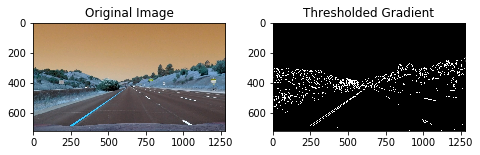

In [31]:
roadImagesDir = "test_images/"

# sampleImage = cv2.imread(calImageFiles[15])

sampleImage = cv2.imread(roadImagesDir + "straight_lines1.jpg")

absSobelImage = ImageTransform.sobelAbsolute(sampleImage, orient="x", thresholds=[20,100])

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24/4, 9/4))
f.tight_layout()
ax1.imshow(sampleImage)
ax1.set_title("Original Image", fontsize=50//4)
ax2.imshow(absSobelImage, cmap="gray")
ax2.set_title("Thresholded Gradient", fontsize=50//4)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)

In [10]:
nx = 9
ny = 6

camera = Camera()
camera.calibrate(calImageFiles, nx, ny)


Calibration in progress: 20 out of 20
Done.


In [15]:
sampleImage = cv2.imread(calImageFiles[15])
undistImage = camera.undistort(sampleImage)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24//4, 9//4))
f.tight_layout()
ax1.imshow(sampleImage)
ax1.set_title("Original Image", fontsize=50//4)
ax2.imshow(undistImage)
ax2.set_title("Undistorted Image", fontsize=50//4)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [8]:
sampleImage = cv2.imread(calImageFiles[4])
topDownImage, perspectiveM = camera.cornersUnwarp(sampleImage, fitToCorners=False, offsetRatioW=0.75, offsetRatioH=0.75)

# topDownImage, perspectiveM = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24/4, 9/4))
f.tight_layout()
ax1.imshow(sampleImage)
ax1.set_title('Original Image', fontsize=50//4)
ax2.imshow(topDownImage)
ax2.set_title('Undistorted and Warped Image', fontsize=50//4)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


(1280, 720)
(720, 1280, 3)


In [ ]:
import glob
import matplotlib
import os

imagesDir = "camera_cal/"
calImageFiles = glob.glob(imagesDir + "*.jpg")

assert len(calImageFiles) > 0, "No image file was found for calibration"

nx = 9
ny = 6

camera = Camera()
camera.calibrate(calImageFiles, nx, ny)

objectPoints = []
imagePoints = []

imageShape = None
sampleImage = None

nx = 9
ny = 6

objGridPoints = np.zeros((nx*ny, 3), dtype=np.float32)
objGridPoints[:, 0:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

for imageIndex, imageFile in enumerate(calImageFiles):
    undistortedImage = cv2.imread(imageFile)
    grayImage = cv2.cvtColor(undistortedImage, cv2.COLOR_BGR2GRAY)
    patternFound, corners = cv2.findChessboardCorners(grayImage, (nx, ny), None)
    
    if(patternFound):
        objectPoints.append(objGridPoints)
        imagePoints.append(np.squeeze(corners))
        
        if(imageShape == None):
            imageShape = (undistortedImage.shape[0], undistortedImage.shape[1])
    
    print("Calibration in progress: {0:d} out of {1:d}".format(imageIndex, len(calImageFiles)), end="\r")

print("")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, imageShape, None, None)

#objPoints[:, 0] = np.mgrid[0:nx, 0:ny][0].reshape((-1))
#objPoints[:, 1] = np.mgrid[0:nx, 0:ny][1].reshape((-1))


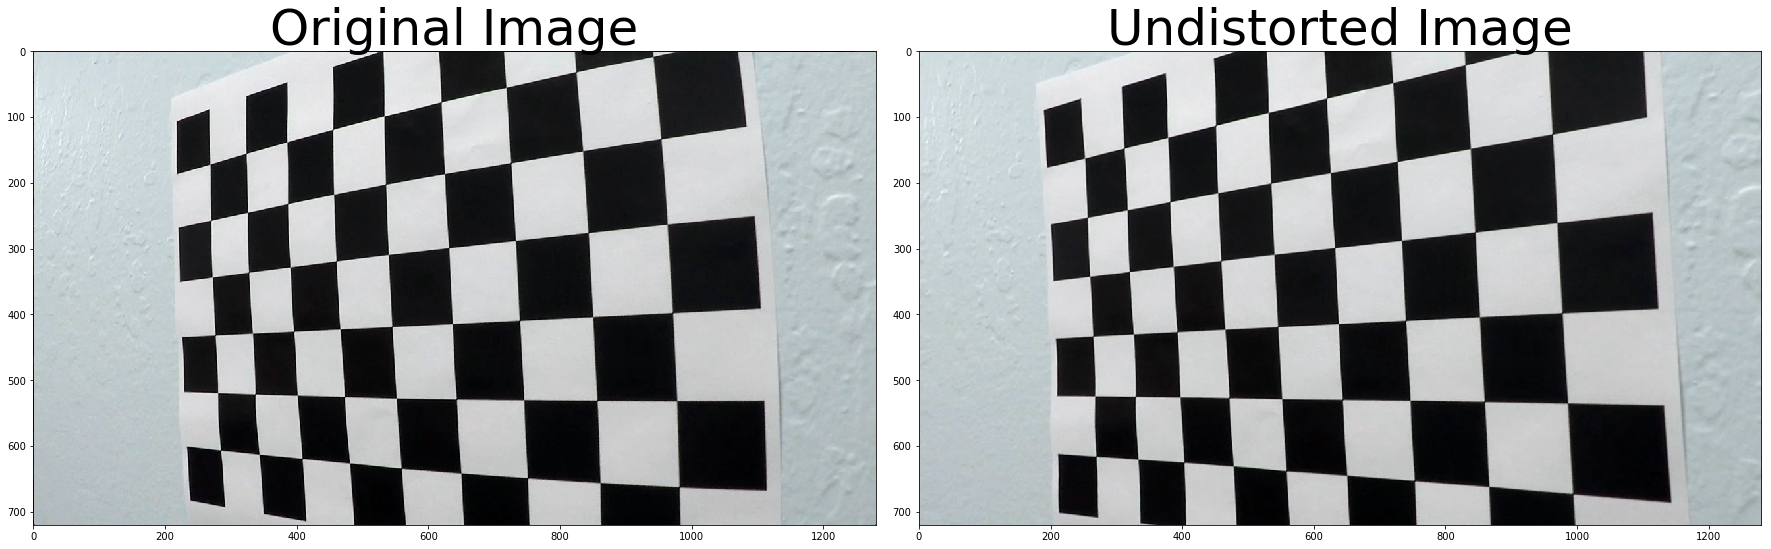

In [144]:
sampleImage = cv2.imread(calImageFiles[14])

undistImage = cv2.undistort(sampleImage, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sampleImage)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistImage)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Calibrate and Undistort

In [5]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "Resources/wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

# Read in an image
img = cv2.imread("Resources/test_image.png")

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    
    # grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imageShape = (img.shape[0], img.shape[1])
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imageShape, None, None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # undist = np.copy(img)  # Delete this line
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

FileNotFoundError: [Errno 2] No such file or directory: 'Resources/wide_dist_pickle.p'

**Note:**

If you are reading in an image using `mpimg.imread()` this will read in an **RGB** image and you should convert to grayscale using `cv2.COLOR_RGB2GRAY`, but if you are using `cv2.imread()` or the glob API, as happens in this video example, this will read in a **BGR** image and you should convert to grayscale using `cv2.COLOR_BGR2GRAY`. We'll learn more about color conversions later on in this lesson, but please keep this in mind as you write your own code and look at code examples.

### Undistort and Transform

Here are the following steps:

- Undistort the image using `cv2.undistort()` with mtx and dist
- Convert to grayscale
- Find the chessboard corners
- Draw corners
- Define 4 source points (the outer 4 corners detected in the chessboard pattern)
- Define 4 destination points (must be listed in the same order as src points!)
- Use `cv2.getPerspectiveTransform()` to get M, the transform matrix
- use `cv2.warpPerspective()` to apply M and warp your image to a top-down view


**HINT:** Source points are the `x` and `y` pixel values of any four corners on your chessboard, you can extract these from the corners array output from `cv2.findChessboardCorners()`. Your destination points are the `x` and `y` pixel values of where you want those four corners to be mapped to in the output image.

***

If you run into any errors as you run your code, please refer to the Examples of Useful Code section in the previous video and make sure that your code syntax matches up! For this example, please also refer back to the examples in the Calibrating Your Camera video. You can also download the [distorsion pickle file](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/correct_for_distortion/wide_dist_pickle.p) and [test image](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/correct_for_distortion/test_image2.png) used in the below quiz if you'd like to run the below code on your own machine.

In [4]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def orderPoints(pts):
    # Ordering: top-left, top-right, bottom-right, bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
 
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
 
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
 
    # return the ordered coordinates
    return rect


(1280, 960)
(960, 1280, 3)
(960, 1280, 3)


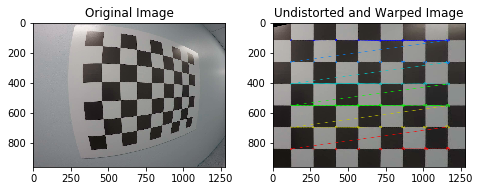

In [5]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "Resources/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread("Resources//test_image2.png")
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # 2) Convert to grayscale
    # 3) Find the chessboard corners
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    #delete the next two lines
    
    undistortedImage = cv2.undistort(img, mtx, dist, None, mtx)
    grayImage = cv2.cvtColor(undistortedImage, cv2.COLOR_BGR2GRAY)
    
    patternFound, corners = cv2.findChessboardCorners(grayImage, (nx, ny), None)
    
    if(patternFound):
        cv2.drawChessboardCorners(undistortedImage, (nx, ny), corners, patternFound)
        
        corners = np.asanyarray(corners).reshape(-1, 2) #.reshape(ny, nx, 2)
        rect = orderPoints(corners)
        
        (tl, tr, br, bl) = rect
        
        # compute the width of the new image, which will be the 
        # maximum distance between bottom-right and bottom-left
        # x-coordiates or the top-right and top-left x-coordinates
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        #maxWidth = max(int(widthA), int(widthB))
        maxWidth = img.shape[1]
        
        # compute the height of the new image, which will be the
        # maximum distance between the top-right and bottom-right
        # y-coordinates or the top-left and bottom-left y-coordinates
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        #maxHeight = max(int(heightA), int(heightB))
        maxHeight = img.shape[0]

        # now that we have the dimensions of the new image, construct
        # the set of destination points to obtain a "birds eye view",
        # (i.e. top-down view) of the image, again specifying points
        # in the top-left, top-right, bottom-right, and bottom-left
        # order
        
        offsetW = 0.75 * maxWidth / nx
        offsetH = 0.75 * maxHeight / ny
        
        # Ordering: top-left, top-right, bottom-right, bottom-left
        
        dest = np.array([
            [offsetW, offsetH],
            [maxWidth - 1 - offsetW, offsetH],
            [maxWidth - 1 - offsetW, maxHeight - 1 - offsetH],
            [offsetW, maxHeight - 1 - offsetH]], dtype = "float32")
        
        print((maxWidth, maxHeight))
        
        M = cv2.getPerspectiveTransform(rect, dest)
        warped = cv2.warpPerspective(undistortedImage, M, (maxWidth, maxHeight))
        
        print(undistortedImage.shape)
        print(warped.shape)
        
    # M = None
    # warped = np.copy(undistortedImage)
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24/4, 9/4))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50//4)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50//4)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Applying Sobel

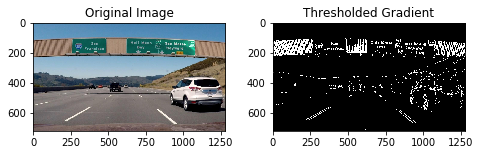

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image and grayscale it
image = mpimg.imread("Lesson-08-Gradient and Color Spaces/Resources/signs_vehicles_xygrad.png")

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=20, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient="x", sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image

    # image was read using mpimg.imread
    grayImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if(orient == "x"):
        sobel = cv2.Sobel(grayImage, cv2.CV_64F, 1, 0)
    elif(orient == "y"):
        sobel = cv2.Sobel(grayImage, cv2.CV_64F, 0, 1)
    else:
        raise Exception("Orient can only be either 'x' or 'y'")
        
    absSobel = np.absolute(sobel)
    scaledSobel = np.uint8(255*absSobel / np.max(absSobel))
    
    binary_output = np.zeros_like(scaledSobel)
    binary_output[(scaledSobel > thresh[0]) & (scaledSobel < thresh[1])] = 1

    # binary_output = np.copy(img) # Remove this line
    return binary_output
    
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh=[20,100])
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24/4, 9/4))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=50//4)
ax2.imshow(grad_binary, cmap="gray")
ax2.set_title("Thresholded Gradient", fontsize=50//4)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)

### Magnitude of the Gradient

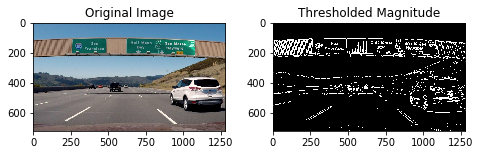

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

# Read in an image
image = mpimg.imread("Lesson-08-Gradient and Color Spaces/Resources/signs_vehicles_xygrad.png")

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    
    # image was read using mpimg.imread
    grayImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelX = cv2.Sobel(grayImage, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(grayImage, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelMagnitude = ((sobelX*sobelX) + (sobelY*sobelY)) ** 0.5
    scaledSobel = np.uint8(255*sobelMagnitude / np.max(sobelMagnitude))
    
    binary_output = np.zeros_like(scaledSobel)
    binary_output[(scaledSobel > mag_thresh[0]) & (scaledSobel < mag_thresh[1])] = 1
    
    # binary_output = np.copy(img) # Remove this line
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24/4, 9/4))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50//4)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50//4)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Direction of the Gradient

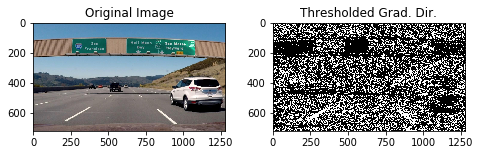

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

# Read in an image
image = mpimg.imread("Lesson-08-Gradient and Color Spaces/Resources/signs_vehicles_xygrad.png")

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    grayImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(grayImage, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(grayImage, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absSobelX = np.abs(sobelX)
    absSobelY = np.abs(sobelY)
    gradDir = np.arctan2(absSobelY, absSobelX)
    
    binary_output = np.zeros_like(gradDir)
    binary_output[(gradDir > thresh[0]) & (gradDir < thresh[1])] = 1
    
    # binary_output = np.copy(img) # Remove this line
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24/4, 9/4))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50//4)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50//4)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combining Thresholds

In [14]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient="x", sobel_kernel=ksize, thresh=(0, 255))
grady = abs_sobel_thresh(image, orient="y", sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

In [15]:
combined = np.zeros_like(dir_binary)
combined[((gradx > 100) & (grady > 100)) | ((mag_binary > 0.7) & (dir_binary > 0.7))] = 1

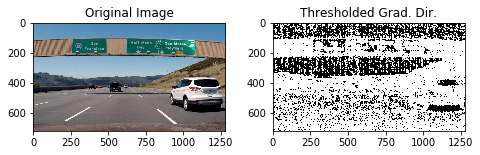

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24/4, 9/4))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=50//4)
ax2.imshow(combined, cmap="gray")
ax2.set_title("Thresholded Grad. Dir.", fontsize=50//4)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)

### HLS Quiz

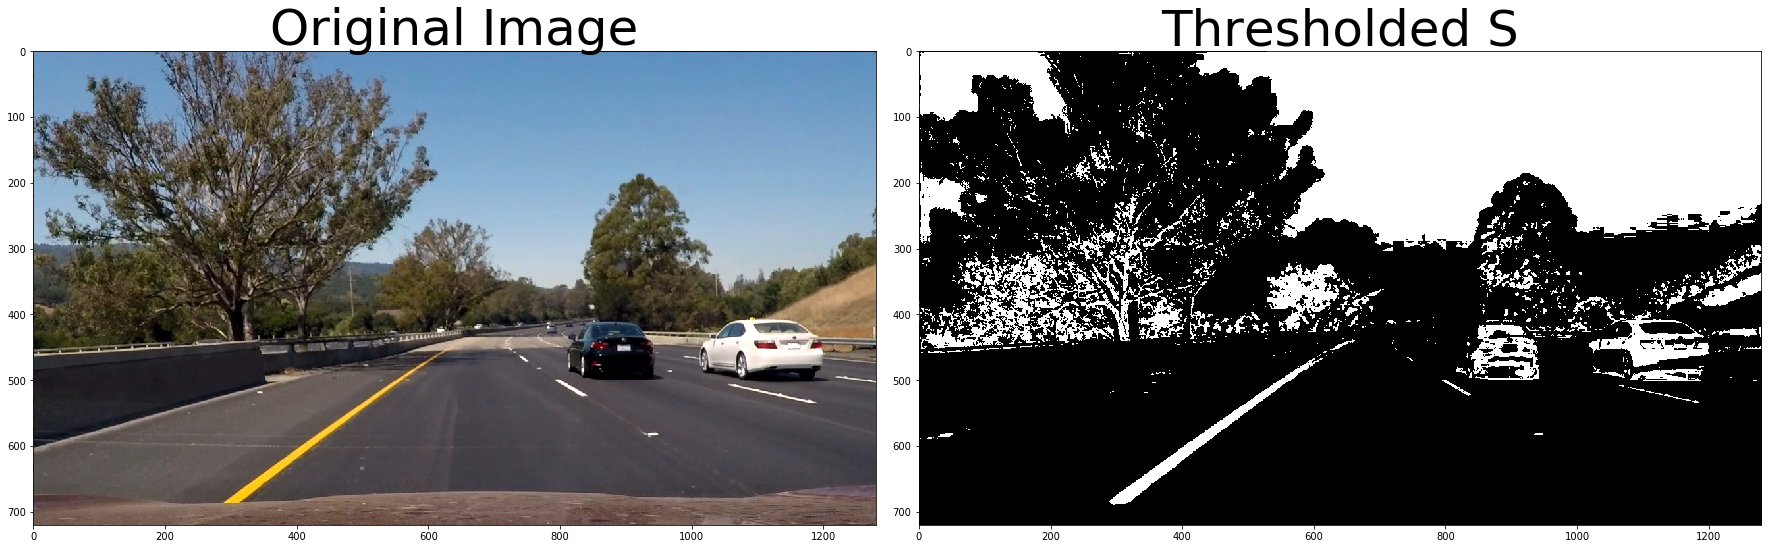

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread("Lesson-08-Gradient and Color Spaces/Resources/test6.jpg")

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    
    hlsImage = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    sChannel = hlsImage[:, :, 2]
    
    binary_output = np.zeros_like(sChannel)
    binary_output[(sChannel > thresh[0]) & (sChannel <= thresh[1])] = 1
    
    # binary_output = np.copy(img) # placeholder line
    return binary_output
    
hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=50)
ax2.imshow(hls_binary, cmap="gray")
ax2.set_title("Thresholded S", fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color and Gradient

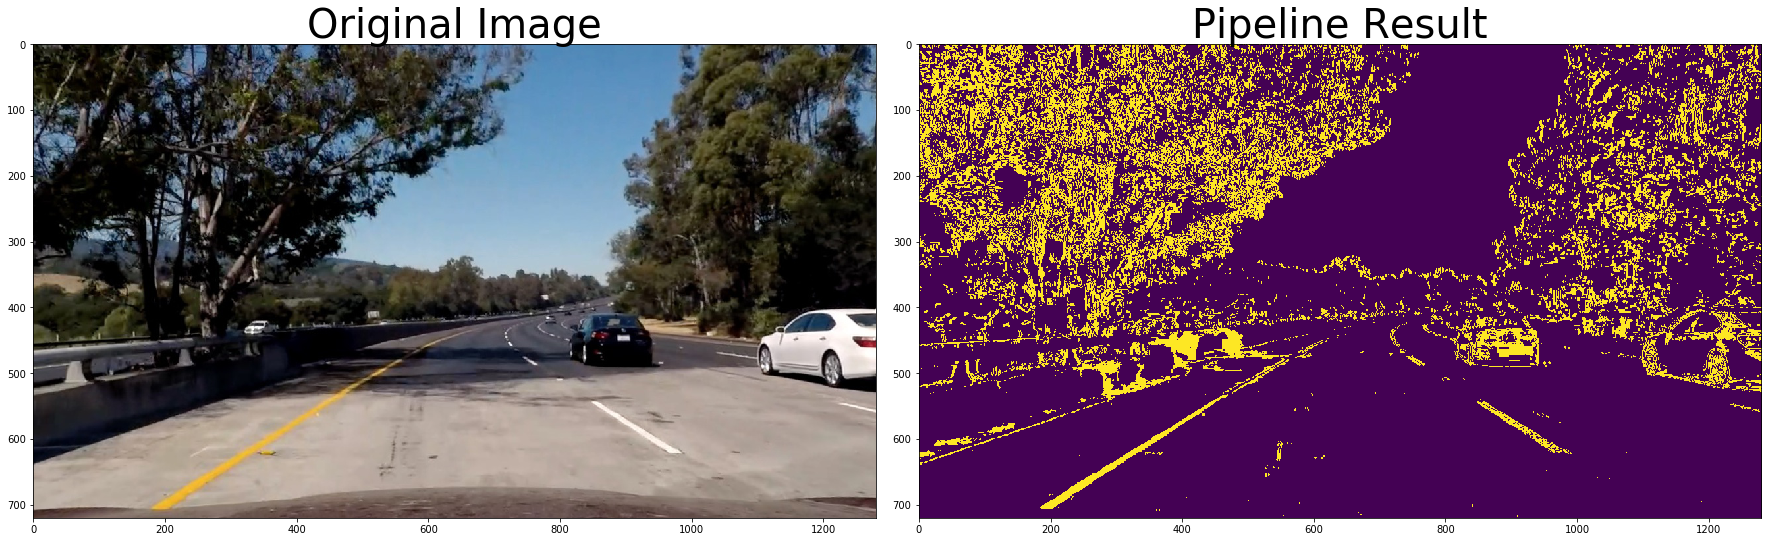

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread("Lesson-08-Gradient and Color Spaces/Resources/bridge_shadow.jpg")

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    #############################
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    color_binary = np.copy(combined_binary)
    #############################
    
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Project-2 Steps

- Camera calibration
- Distortion correction
- Color/gradient threshold
- Perspective transform


After doing these steps, you’ll be given two additional steps for the project:

- Detect lane lines
- Determine the lane curvature

### Finding the Lines: Histogram Peaks

In [ ]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread("Leson-09-Advanced Computer Vision/Resources/warped_example.jpg") / 255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = None

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = None
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

### Finding the Lines: Sliding Window

[ 6.48480188e-04 -3.89787325e-01  1.80962019e+02]
[ 9.11100134e-04 -4.54504939e-01  4.30342612e+02]


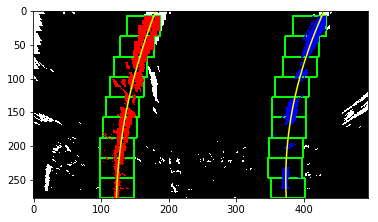

In [95]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
binary_warped = mpimg.imread("Lesson-09-Advanced Computer Vision/Resources/warped_example.jpg")
binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
# (thresh, im_bw) = cv2.threshold(binary_warped, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

thresh = 127
binary_warped = cv2.threshold(binary_warped, thresh, 255, cv2.THRESH_BINARY)[1]

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100 // 4
    # Set minimum number of pixels found to recenter window
    minpix = 50 // 4
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    nonzeroArray = np.array(nonzero)#.reshape(-1, 2)
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window #
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # return out_img
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    print(left_fit)
    print(right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)

### Finding the Lines: Search from Prior

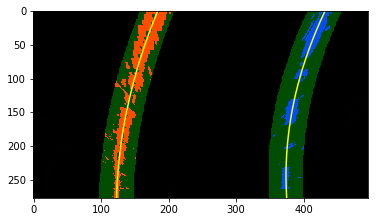

In [103]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread("Lesson-09-Advanced Computer Vision/Resources/warped_example.jpg")
binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
thresh = 127
binary_warped = cv2.threshold(binary_warped, thresh, 255, cv2.THRESH_BINARY)[1]

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!

#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

left_fit = np.array([ 6.48480188e-04, -3.89787325e-01, 1.80962019e+02])
right_fit = np.array([ 9.11100134e-04, -4.54504939e-01, 4.30342612e+02])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100 // 4

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)


### Measuring Curvature I
- Generate some fake data first

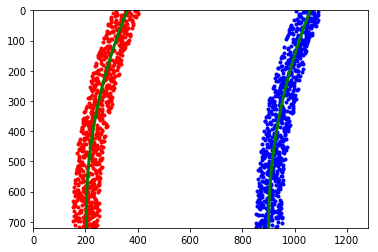

In [111]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [112]:
leftx = np.array([0, 1, 2, 3, 4, 5, 6, 7])

print(leftx)
leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
print(leftx)

[0 1 2 3 4 5 6 7]
[7 6 5 4 3 2 1 0]


### Measuring Curvature I
- Implementing the calculation itself

In [113]:
import numpy as np

def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit
    
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

1625.0601831657232 1976.2967307714703


### Measuring Curvature II
- From Pixels to Real-World

In [114]:
import numpy as np

def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr
    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

533.7525889210916 m 648.1574851434274 m


### Bonus Round: Computer Vision

Lane Finding with Semantic Segmentation
The below papers and resources concern a technique called semantic segmentation, where each pixel of an image gets classified individually!

- [Fully Convolutional Networks for Semantic Segmentation by E. Shelhamer, J. Long and T. Darrell](https://arxiv.org/abs/1605.06211)

    >**Abstract:** Convolutional networks are powerful visual models that yield hierarchies of features. We show that convolutional networks by themselves, trained end-to-end, pixels-to-pixels, improve on the previous best result in semantic segmentation. Our key insight is to build "fully convolutional" networks that take input of arbitrary size and produce correspondingly-sized output with efficient inference and learning. We define and detail the space of fully convolutional networks, explain their application to spatially dense prediction tasks, and draw connections to prior models. We adapt contemporary classification networks (AlexNet, the VGG net, and GoogLeNet) into fully convolutional networks and transfer their learned representations by fine-tuning to the segmentation task. We then define a skip architecture that combines semantic information from a deep, coarse layer with appearance information from a shallow, fine layer to produce accurate and detailed segmentations. [...]
    
    You can use the [KITTI road dataset](http://www.cvlibs.net/datasets/kitti/eval_road.php) with the above technique for a model that can detect open space on the road.
 
 
- [Lane Detection with Deep Learning (Part 1)](https://towardsdatascience.com/lane-detection-with-deep-learning-part-1-9e096f3320b7) and [(Part 2)](https://towardsdatascience.com/lane-detection-with-deep-learning-part-2-3ba559b5c5af) by M. Virgo

    >**Summary:** Udacity SDC student (and now Udacian!) investigates using a deep learning approach to lane detection in order to improve upon the Advanced Lane Finding project, eventually building a model with a fully convolutional neural network that detects the road is a wider variety of situations and at faster speed.
    
***
**Other Lane Finding Techniques**  
The below paper uses a multi-task model to identify lane and road markings, as well as vanishing point of the road, in order to build a robust model.

- [VPGNet: Vanishing Point Guided Network for Lane and Road Marking Detection and Recognition](https://arxiv.org/abs/1710.06288) by S. Lee, et. al  

    >**Abstract:** In this paper, we propose a unified end-to-end trainable multi-task network that jointly handles lane and road marking detection and recognition that is guided by a vanishing point under adverse weather conditions. We tackle rainy and low illumination conditions [...] At night, color distortion occurs under limited illumination. As a result, no benchmark dataset exists and only a few developed algorithms work under poor weather conditions. To address this shortcoming, we build up a lane and road marking benchmark which consists of about 20,000 images with 17 lane and road marking classes under four different scenarios: no rain, rain, heavy rain, and night. We train and evaluate several versions of the proposed multi-task network and validate the importance of each task. The resulting approach, VPGNet, can detect and classify lanes and road markings, and predict a vanishing point with a single forward pass. Experimental results show that our approach achieves high accuracy and robustness under various conditions in real-time (20 fps). [...]

***

**Vehicle Detection**  
The below paper builds a model to both detect vehicles as well as estimate their dimensions along the road.

- [Learning to Map Vehicles into Bird's Eye View](https://arxiv.org/abs/1706.08442) by A. Palazzi, et. al.

    >**Abstract:** Awareness of the road scene is an essential component for both autonomous vehicles and Advances Driver Assistance Systems and is gaining importance both for the academia and car companies. This paper presents a way to learn a semantic-aware transformation which maps detections from a dashboard camera view onto a broader bird's eye occupancy map of the scene. To this end, a huge synthetic dataset featuring 1M couples of frames, taken from both car dashboard and bird's eye view, has been collected and automatically annotated. A deep-network is then trained to warp detections from the first to the second view. We demonstrate the effectiveness of our model against several baselines and observe that is able to generalize on real-world data despite having been trained solely on synthetic ones.